In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
model = joblib.load("../model/sales_forecast_model_v1.joblib")
feature_cols = joblib.load("../model/feature_columns_v1.joblib")

df = pd.read_csv("../data/processed/model_input.csv")

df.head()


,Store,Promo,Promo2,CompetitionDistance,HasCompetition,DayOfWeek,IsWeekend,WeekOfYear,Quarter,Sales_Lag_1,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_7,Sales_Rolling_30,Sales
0,2,1,1,570.0,1,2,0,6,1,6269.0,3461.0,4422.0,4642.428571,4514.033333,6438
1,2,1,1,570.0,1,3,0,6,1,6438.0,4446.0,4159.0,5067.714286,4581.233333,5575
2,2,1,1,570.0,1,4,0,6,1,5575.0,4340.0,4484.0,5229.000000,4628.433333,4203
3,2,0,1,570.0,1,5,1,6,1,4203.0,4545.0,2342.0,5209.428571,4619.066667,3031
4,2,0,1,570.0,1,0,0,7,1,3031.0,2956.0,6775.0,4993.142857,4642.033333,4303


In [3]:
# We assume model_input.csv contains historical daily data
df = df.sort_values(by="Store").copy()


In [4]:
X = df[feature_cols]
df['Predicted_Sales'] = model.predict(X)


In [5]:
# Load raw data to get exact dates
train = pd.read_csv("../data/raw/train.csv")
train['Date'] = pd.to_datetime(train['Date'])

df['Date'] = train['Date']  # align date from raw

monthly_actual = df.groupby(df['Date'].dt.to_period('M'))['Sales'].sum()
monthly_pred = df.groupby(df['Date'].dt.to_period('M'))['Predicted_Sales'].sum()

forecast_df = pd.DataFrame({
    "Actual": monthly_actual,
    "Predicted": monthly_pred
})

forecast_df.index = forecast_df.index.to_timestamp()
forecast_df.tail()


C:\Users\Rohith Kumar\AppData\Local\Temp\ipykernel_24568\3941352529.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/raw/train.csv")


,Actual,Predicted
Date,,
2015-03-01,219262506,2.192852e+08
2015-04-01,238281956,2.380573e+08
2015-05-01,234718408,2.349185e+08
2015-06-01,211129040,2.113150e+08
2015-07-01,227339801,2.272048e+08


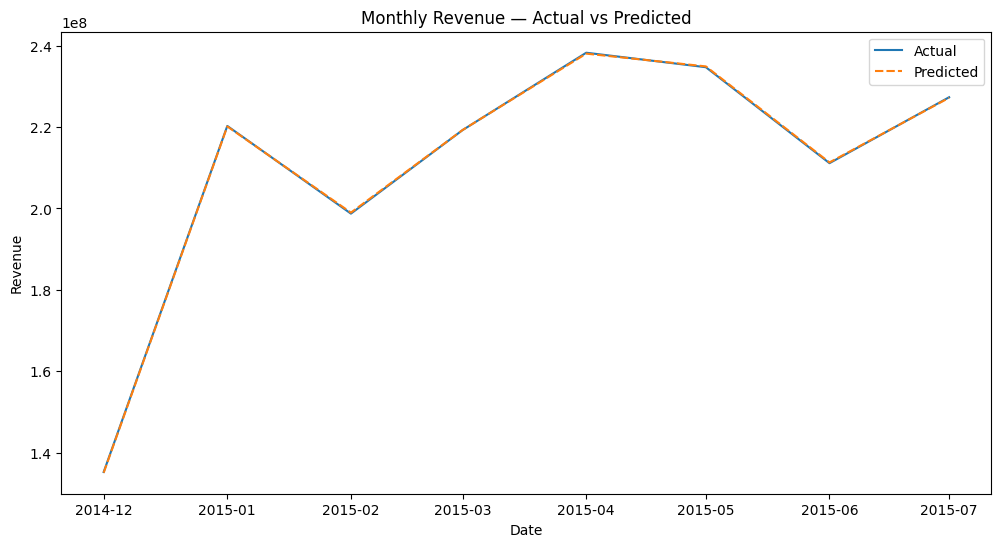

In [6]:
plt.figure(figsize=(12,6))
sns.lineplot(data=forecast_df[['Actual','Predicted']])
plt.title("Monthly Revenue — Actual vs Predicted")
plt.ylabel("Revenue")
plt.show()


In [7]:
last_df = df.copy()
last_df = last_df.sort_values("Date")
last_date = last_df['Date'].max()

last_date


Timestamp('2015-07-31 00:00:00')

In [8]:
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=90,   # ~3 months daily
    freq="D"
)

future = pd.DataFrame({"Date": future_dates})


In [9]:
# Use average store-level inputs for simplicity
template = last_df.iloc[-1].copy()

for col in feature_cols:
    if col not in future.columns and col != 'Sales':
        future[col] = template[col]


In [10]:
future['Year'] = future['Date'].dt.year
future['Month'] = future['Date'].dt.month
future['DayOfWeek'] = future['Date'].dt.dayofweek


In [12]:
history = pd.concat(
    [
        history,
        pd.DataFrame({'Date': future['Date'], 'Sales': np.nan})
    ],
    ignore_index=True
).sort_values('Date')
for lag in [1,7,30]:
    history[f'Sales_Lag_{lag}'] = history['Sales'].shift(lag)

for win in [7,30]:
    history[f'Sales_Rolling_{win}'] = history['Sales'].shift(1).rolling(win).mean()


In [13]:
future_X = future[feature_cols]
future['Forecast_Sales'] = model.predict(future_X)


In [14]:
future['Month'] = future['Date'].dt.to_period('M')
monthly_future = future.groupby('Month')['Forecast_Sales'].sum()

monthly_future


Month
2015-08    162763.658426
2015-09    159156.096090
2015-10    153480.179221
Freq: M, Name: Forecast_Sales, dtype: float64

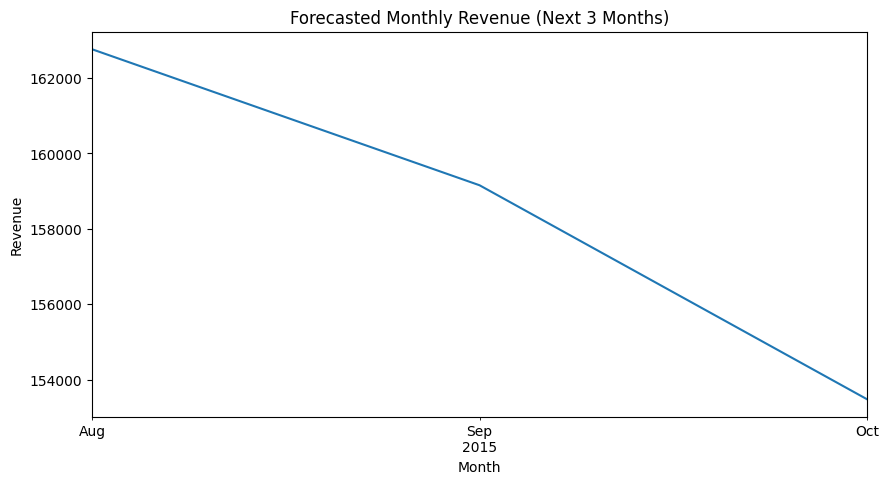

In [15]:
plt.figure(figsize=(10,5))
monthly_future.plot(kind='line')
plt.title("Forecasted Monthly Revenue (Next 3 Months)")
plt.ylabel("Revenue")
plt.show()


In [16]:
monthly_future.to_csv("../reports/monthly_forecast.csv")
print("Saved → reports/monthly_forecast.csv")


Saved → reports/monthly_forecast.csv
